In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [ ]:
df = pd.read_excel('rut.xlsx')
df.index = pd.to_datetime(df['Date'])
df

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,Return,segment,Labels
Date,,,,,,,,,,,
2017-01-06,0,2017-01-06,1372.489990,1375.060059,1366.819946,1367.280029,1367.280029,3339890000,0.001311,0,Sabit
2017-01-09,1,2017-01-09,1367.130005,1367.130005,1356.540039,1357.489990,1357.489990,3217610000,-0.021946,2,Azalan Trend
2017-01-10,2,2017-01-10,1357.739990,1371.500000,1357.739990,1370.900024,1370.900024,3638790000,-0.000758,0,Sabit
2017-01-11,3,2017-01-11,1370.890015,1375.540039,1365.140015,1373.300049,1373.300049,3620410000,0.004403,0,Sabit
2017-01-12,4,2017-01-12,1372.839966,1372.839966,1346.810059,1361.069946,1361.069946,3462130000,0.002637,0,Sabit
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1251,2021-12-27,2242.479980,2261.889893,2230.330078,2261.459961,2261.459961,2264120000,0.026560,3,Artan Trend
2021-12-28,1252,2021-12-28,2261.040039,2274.540039,2245.570068,2246.510010,2246.510010,2217050000,0.011076,3,Artan Trend
2021-12-29,1253,2021-12-29,2246.350098,2252.790039,2236.649902,2249.239990,2249.239990,2369370000,0.003417,0,Sabit


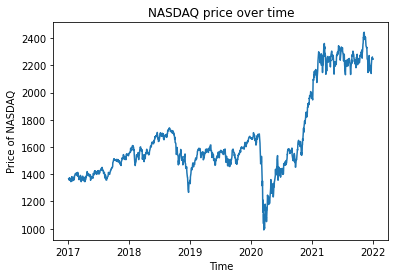

In [ ]:
plt.plot(df['Adj Close'])
plt.xlabel("Time")
plt.ylabel("Price of NASDAQ")
plt.title("NASDAQ price over time")
plt.savefig("initial_plot.png", dpi=250)
plt.show();

In [ ]:
close = df[['Adj Close']]
print(close.shape)

(1256, 1)


In [ ]:
tf.random.set_seed(1234)

In [ ]:
# Split train data and test data
trainval_size = int(len(close)*0.97)

trainval_data = close.iloc[:trainval_size]
test_data = close.iloc[trainval_size:]

#Validation
train_size = int(len(trainval_data)*0.9)

train_data = trainval_data.iloc[:train_size]
val_data = trainval_data.iloc[train_size:]

In [ ]:
scaler = MinMaxScaler().fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)
val_scaled = scaler.transform(val_data)

In [ ]:
# Create input dataset
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
 
    return np.array(Xs), np.array(ys)

In [ ]:
LOOK_BACK = 20
X_train, y_train = create_dataset(train_scaled,LOOK_BACK)
X_test, y_test = create_dataset(test_scaled,LOOK_BACK)
X_val, y_val = create_dataset(val_scaled, LOOK_BACK)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((1076, 20, 1), (1076, 1), (18, 20, 1), (18, 1), (102, 20, 1), (102, 1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((20, 1)))
model1.add(LSTM(128, return_sequences=True))
#model1.add(Dropout(0.2))
model1.add(LSTM(64, return_sequences=False))
#model1.add(Dropout(0.2))
model1.add(Dense(25, 'sigmoid'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

In [ ]:
history = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[cp1])

Epoch 1/50
33/34 [============================>.] - ETA: 0s - loss: 0.0344 - root_mean_squared_error: 0.1855

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


34/34 [==============================] - 16s 349ms/step - loss: 0.0338 - root_mean_squared_error: 0.1839 - val_loss: 0.0420 - val_root_mean_squared_error: 0.2048
Epoch 2/50
33/34 [============================>.] - ETA: 0s - loss: 0.0028 - root_mean_squared_error: 0.0528

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


34/34 [==============================] - 10s 312ms/step - loss: 0.0027 - root_mean_squared_error: 0.0524 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0407
Epoch 3/50
33/34 [============================>.] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0352

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


34/34 [==============================] - 10s 316ms/step - loss: 0.0013 - root_mean_squared_error: 0.0358 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0380
Epoch 4/50
33/34 [============================>.] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0345

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


34/34 [==============================] - 10s 316ms/step - loss: 0.0012 - root_mean_squared_error: 0.0346 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0350
Epoch 5/50
34/34 [==============================] - 1s 35ms/step - loss: 0.0010 - root_mean_squared_error: 0.0320 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0380
Epoch 6/50
33/34 [============================>.] - ETA: 0s - loss: 8.6605e-04 - root_mean_squared_error: 0.0294

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


34/34 [==============================] - 10s 300ms/step - loss: 8.5578e-04 - root_mean_squared_error: 0.0293 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0337
Epoch 7/50
34/34 [==============================] - ETA: 0s - loss: 9.6369e-04 - root_mean_squared_error: 0.0310

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


34/34 [==============================] - 11s 332ms/step - loss: 9.6369e-04 - root_mean_squared_error: 0.0310 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0332
Epoch 8/50
34/34 [==============================] - 1s 35ms/step - loss: 9.4476e-04 - root_mean_squared_error: 0.0307 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0342
Epoch 9/50
34/34 [==============================] - 1s 34ms/step - loss: 6.2397e-04 - root_mean_squared_error: 0.0250 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0339
Epoch 10/50
33/34 [============================>.] - ETA: 0s - loss: 8.5529e-04 - root_mean_squared_error: 0.0292

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


34/34 [==============================] - 10s 315ms/step - loss: 8.4808e-04 - root_mean_squared_error: 0.0291 - val_loss: 9.5068e-04 - val_root_mean_squared_error: 0.0308
Epoch 11/50
33/34 [============================>.] - ETA: 0s - loss: 6.4459e-04 - root_mean_squared_error: 0.0254

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


34/34 [==============================] - 10s 304ms/step - loss: 6.3857e-04 - root_mean_squared_error: 0.0253 - val_loss: 8.8689e-04 - val_root_mean_squared_error: 0.0298
Epoch 12/50
34/34 [==============================] - 1s 36ms/step - loss: 6.1434e-04 - root_mean_squared_error: 0.0248 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0362
Epoch 13/50
34/34 [==============================] - 1s 35ms/step - loss: 4.8855e-04 - root_mean_squared_error: 0.0221 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0493
Epoch 14/50
33/34 [============================>.] - ETA: 0s - loss: 5.2565e-04 - root_mean_squared_error: 0.0229

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


34/34 [==============================] - 12s 362ms/step - loss: 5.2139e-04 - root_mean_squared_error: 0.0228 - val_loss: 7.1634e-04 - val_root_mean_squared_error: 0.0268
Epoch 15/50
34/34 [==============================] - 1s 35ms/step - loss: 6.3506e-04 - root_mean_squared_error: 0.0252 - val_loss: 7.7651e-04 - val_root_mean_squared_error: 0.0279
Epoch 16/50
34/34 [==============================] - 1s 35ms/step - loss: 7.5556e-04 - root_mean_squared_error: 0.0275 - val_loss: 7.5833e-04 - val_root_mean_squared_error: 0.0275
Epoch 17/50
34/34 [==============================] - 1s 35ms/step - loss: 5.0435e-04 - root_mean_squared_error: 0.0225 - val_loss: 9.5787e-04 - val_root_mean_squared_error: 0.0309
Epoch 18/50
34/34 [==============================] - 1s 36ms/step - loss: 3.8341e-04 - root_mean_squared_error: 0.0196 - val_loss: 7.8889e-04 - val_root_mean_squared_error: 0.0281
Epoch 19/50
33/34 [============================>.] - ETA: 0s - loss: 4.0467e-04 - root_mean_squared_error: 0.0

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


34/34 [==============================] - 10s 300ms/step - loss: 4.1411e-04 - root_mean_squared_error: 0.0203 - val_loss: 6.2610e-04 - val_root_mean_squared_error: 0.0250
Epoch 20/50
33/34 [============================>.] - ETA: 0s - loss: 3.5774e-04 - root_mean_squared_error: 0.0189

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


34/34 [==============================] - 11s 321ms/step - loss: 3.5500e-04 - root_mean_squared_error: 0.0188 - val_loss: 6.0364e-04 - val_root_mean_squared_error: 0.0246
Epoch 21/50
34/34 [==============================] - 1s 34ms/step - loss: 4.9722e-04 - root_mean_squared_error: 0.0223 - val_loss: 8.3593e-04 - val_root_mean_squared_error: 0.0289
Epoch 22/50
34/34 [==============================] - 1s 35ms/step - loss: 6.8622e-04 - root_mean_squared_error: 0.0262 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0324
Epoch 23/50
34/34 [==============================] - 1s 35ms/step - loss: 3.5649e-04 - root_mean_squared_error: 0.0189 - val_loss: 9.7366e-04 - val_root_mean_squared_error: 0.0312
Epoch 24/50
34/34 [==============================] - 1s 35ms/step - loss: 4.2904e-04 - root_mean_squared_error: 0.0207 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0346
Epoch 25/50
33/34 [============================>.] - ETA: 0s - loss: 3.7693e-04 - root_mean_squared_error: 0.0194

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


34/34 [==============================] - 10s 309ms/step - loss: 3.7455e-04 - root_mean_squared_error: 0.0194 - val_loss: 5.1935e-04 - val_root_mean_squared_error: 0.0228
Epoch 26/50
33/34 [============================>.] - ETA: 0s - loss: 3.9610e-04 - root_mean_squared_error: 0.0199

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


34/34 [==============================] - 10s 307ms/step - loss: 4.0083e-04 - root_mean_squared_error: 0.0200 - val_loss: 4.8587e-04 - val_root_mean_squared_error: 0.0220
Epoch 27/50
33/34 [============================>.] - ETA: 0s - loss: 5.0171e-04 - root_mean_squared_error: 0.0224

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


34/34 [==============================] - 11s 322ms/step - loss: 4.9788e-04 - root_mean_squared_error: 0.0223 - val_loss: 4.7878e-04 - val_root_mean_squared_error: 0.0219
Epoch 28/50
34/34 [==============================] - 1s 35ms/step - loss: 3.5429e-04 - root_mean_squared_error: 0.0188 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0361
Epoch 29/50
33/34 [============================>.] - ETA: 0s - loss: 4.0917e-04 - root_mean_squared_error: 0.0202

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


34/34 [==============================] - 11s 318ms/step - loss: 4.2024e-04 - root_mean_squared_error: 0.0205 - val_loss: 4.4719e-04 - val_root_mean_squared_error: 0.0211
Epoch 30/50
34/34 [==============================] - 1s 36ms/step - loss: 6.4813e-04 - root_mean_squared_error: 0.0255 - val_loss: 4.8191e-04 - val_root_mean_squared_error: 0.0220
Epoch 31/50
34/34 [==============================] - 1s 35ms/step - loss: 3.8370e-04 - root_mean_squared_error: 0.0196 - val_loss: 6.1016e-04 - val_root_mean_squared_error: 0.0247
Epoch 32/50
34/34 [==============================] - 1s 36ms/step - loss: 3.5728e-04 - root_mean_squared_error: 0.0189 - val_loss: 5.3557e-04 - val_root_mean_squared_error: 0.0231
Epoch 33/50
34/34 [==============================] - 1s 35ms/step - loss: 3.6301e-04 - root_mean_squared_error: 0.0191 - val_loss: 5.0626e-04 - val_root_mean_squared_error: 0.0225
Epoch 34/50
34/34 [==============================] - 1s 35ms/step - loss: 5.2363e-04 - root_mean_squared_error

In [ ]:
from tensorflow.keras.models import load_model
model1 = load_model('model1')

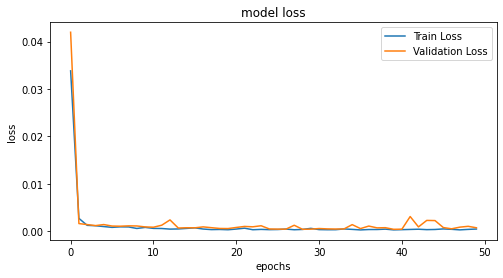

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train.flatten()})
train_results

,Train Predictions,Actuals
0,0.243965,0.274286
1,0.241517,0.270195
2,0.234346,0.268501
3,0.230503,0.282956
4,0.242862,0.290487
...,...,...
1071,0.932178,0.892280
1072,0.902112,0.888109
1073,0.900775,0.835626
1074,0.857977,0.861783


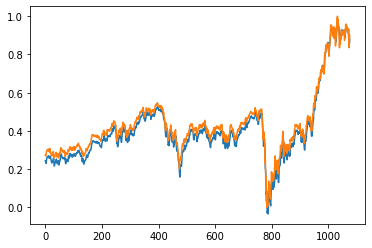

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][:3000])
plt.plot(train_results['Actuals'][:3000])

In [ ]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test.flatten()})
test_results

,Test Predictions,Actuals
0,0.905937,0.922294
1,0.925970,0.935384
2,0.937191,0.897766
3,0.909828,0.891630
4,0.903633,0.868759
5,0.882748,0.853529
6,0.873405,0.879504
7,0.892490,0.848277
8,0.869884,0.863960
9,0.883061,0.839081


In [ ]:
inv_scaled = scaler.inverse_transform(test_results)

In [ ]:
inv_scaled = pd.DataFrame(inv_scaled)
inv_scaled

,0,1
0,2231.397169,2253.790039
1,2258.822385,2271.709961
2,2274.183136,2220.209961
3,2236.723159,2211.810059
4,2228.242864,2180.500000
5,2199.650941,2159.649902
6,2186.859427,2195.209961
7,2212.988192,2152.459961
8,2182.039353,2173.929932
9,2200.079011,2139.870117


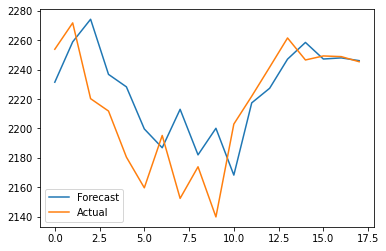

In [ ]:
import matplotlib.pyplot as plt
plt.plot(inv_scaled[0], label='Forecast')
plt.plot(inv_scaled[1], label='Actual')
plt.legend(loc='lower left')

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
# calculate RMSE
rmse = sqrt(mse(inv_scaled[1], inv_scaled[0]))
mape = np.mean(np.abs(inv_scaled[1] - inv_scaled[0])/np.abs(inv_scaled[1]))
mae = np.mean(np.abs(inv_scaled[0] - inv_scaled[1])) 
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)

Test RMSE: 30.989
Test MAPE: 0.011
Test MAE: 23.477
